# Trabalho 1 - Inventário de emissões com Python
Desenvolvedores: José Henrique Hess e Kezia Bernarda de Oliveira

In [266]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
from matplotlib.ticker import FuncFormatter

## Ler planilha dos fatores de emissão e estimar a emissão com base na taxa de atividade do empreendimento.
Foi utilizado o capítulo 12.13 da AP42, pois a fundição de aço é a mais representativa da empresa WEG.
Link: https://www.epa.gov/sites/default/files/2020-11/documents/c12s13.pdf

In [226]:
# Coletando o caminho da pasta que estou
cwd = os.getcwd()

# Pasta dos fatores de emissão
path = os.path.join(cwd, 'tabelas', 'FE')

# Indicando nome do arquivo
chapterNumer = 12
subChapter = 13
file = f'chp_{chapterNumer}_{subChapter}.csv'
print(file)

# Diretório do arquivo completo
full_path = os.path.join(path, file)
print(full_path)

# Abrindo o arquivo utilizando o pandas
fe = pd.read_csv(full_path, encoding='utf-8')
print(fe)

chp_12_13.csv
C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\FE\chp_12_13.csv
                 Processo  Particula Filtravel  NOx  PM10
0                   Fusão                  6.5  0.1   NaN
1  Manuseio Areia (areia)                  NaN  NaN  0.27
2    Manuseio Areia (aço)                  NaN  NaN  3.00
3          Fornos (areia)                  NaN  NaN  1.11
4            Fornos (aço)                  NaN  NaN  0.45
5            Derramamento                  NaN  NaN  1.40
6                 Limpeza                  NaN  NaN  0.85
7              Tratamento                  NaN  NaN  0.18
8            Resfriamento                  NaN  NaN  0.70


0
0
1
2
3
4
5
6
7
8


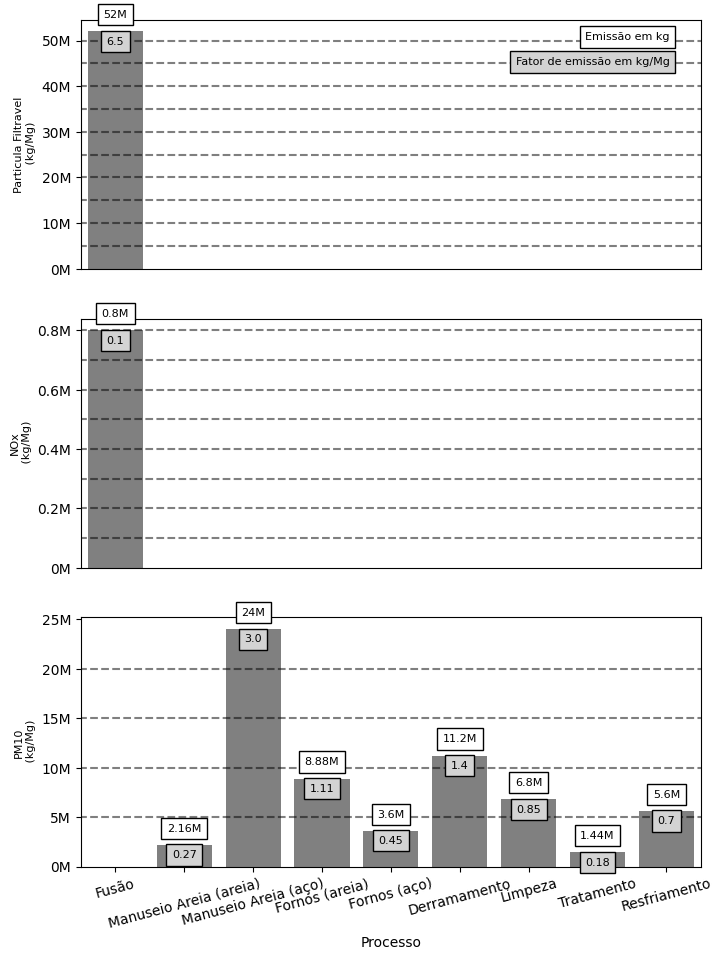

In [255]:
# Plotando os fatores de emissão

# Função para formatar os rótulos em milhões
def milhao(x, pos):
    if x % 1e6 == 0:
        return '%1.0fM' % (x * 1e-6)
    elif x % 1e5 == 0:
        return '%1.1fM' % (x * 1e-6)
    else:
        return '%1.2fM' % (x * 1e-6)

atv = 8000000 # Considerando a taxa de atividade igual a 40% do total de motores produzidos pela WEG
# print(atv)

# Criando a figura com Matplotlib
# Subplots com número de linhas igual ao número de poluentes
# Sharex significa compartilhar eixo x
fig,ax = plt.subplots(len(fe.columns)-1,1,sharex=True,figsize=(8,11))

#Loop para preencher o subplot com os gráficos de barra
for ii in range(1,len(fe.columns)):
    barras = ax[ii-1].bar(fe['Processo'], atv * fe.iloc[:, ii], color='gray')
    
    # Anotando o valor de cada barra e o fator de emissão de cada barra
    for barra in barras:
        altura = barra.get_height()
        if np.isfinite(altura):  # Verificando se a altura não é nan
            i = round((barra.get_x())-0.6)+1
            print(i)
            # Adicionando os valores totais de emissão e de fator de emissão
            ax[ii-1].text(barra.get_x() + barra.get_width() / 2, altura + 0.05 * atv*fe.iloc[:,ii].max(), milhao(altura, None),
                          ha='center', va='bottom', fontsize=8,
                          bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
            ax[ii-1].text(barra.get_x() + barra.get_width() / 2, altura - 0.02 * atv*fe.iloc[:,ii].max(), fe.iloc[i, ii],
                          ha='center', va='top', fontsize=8,
                          bbox=dict(facecolor='lightgray', alpha=1, edgecolor='black'))

    # Explicação dos textos
    if ii == 1:
        ax[ii-1].text(0.95, 0.95, 'Emissão em kg', transform=ax[ii-1].transAxes, fontsize=8,
                      verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=1))
        ax[ii-1].text(0.95, 0.85, 'Fator de emissão em kg/Mg', transform=ax[ii-1].transAxes, fontsize=8,
                      verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='lightgray', alpha=1))

    # If Else para deixar o eixo x apenas no último gráfico
    if ax[2] == ax[ii-1]:
        ax[ii-1].set_xlabel('Processo')
        ax[ii-1].set_xticks(range(len(fe['Processo'])))
        ax[ii-1].set_xticklabels(fe['Processo'], rotation=15)
    else: 
        ax[ii-1].xaxis.set_visible(False)
    ax[ii-1].set_ylabel(fe.columns[ii]+'\n (kg/Mg)',fontsize=8)

    # Configura o formatter para milhões
    formatter = FuncFormatter(milhao)
    ax[ii-1].yaxis.set_major_formatter(formatter)

    # Limitando o tamanho do eixo x
    ax[ii-1].set_xlim(-0.5,8.5)

    # Estabelecendo linhas pontilhadas no gráfico
    for i in range(1,int(atv*fe.iloc[:,ii].max())+1):
        if i%100000 == 0:
            if int(atv*fe.iloc[:,ii].max()) < 1000000:
                ax[ii-1].hlines(y=i,xmin=-1,xmax=9, alpha=0.5,linestyle='dashed', colors = 'black')
            else: 
                if i%5000000 == 0:
                    ax[ii-1].hlines(y=i,xmin=-1,xmax=9, alpha=0.5,linestyle='dashed', colors = 'black')

# Salva a figura na pasta figures - criar a pasta antes
fig.savefig(cwd+'\\figures\\barplot_fatorEmiss.png')

In [256]:
# Criando vetor de datas
import pandas as pd

# Criar um intervalo de datas
datas = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='h')

# Criar um DataFrame com as datas
df = pd.DataFrame({'Data': datas})

# Extrair os meses das datas e adicioná-los como uma nova coluna no DataFrame
df['Mes'] = df['Data'].dt.month

# Criando valor da semana 
sem = np.full(len(df),1)
for i in range(167,8760,168):
    sem[i:] += 1
df['Semana'] = sem

# Mostrar o DataFrame resultante
print(df)

                    Data  Mes  Semana
0    2023-01-01 00:00:00    1       1
1    2023-01-01 01:00:00    1       1
2    2023-01-01 02:00:00    1       1
3    2023-01-01 03:00:00    1       1
4    2023-01-01 04:00:00    1       1
...                  ...  ...     ...
8755 2023-12-31 19:00:00   12      53
8756 2023-12-31 20:00:00   12      53
8757 2023-12-31 21:00:00   12      53
8758 2023-12-31 22:00:00   12      53
8759 2023-12-31 23:00:00   12      53

[8760 rows x 3 columns]


1095
730
                    Data  Mes  Semana    atividade  sazonalidade  \
0    2023-01-01 00:00:00    1       1   884.000038         365.0   
1    2023-01-01 01:00:00    1       1   781.110224         365.0   
2    2023-01-01 02:00:00    1       1   748.524491         365.0   
3    2023-01-01 03:00:00    1       1  1070.151725         365.0   
4    2023-01-01 04:00:00    1       1   893.513950         365.0   
...                  ...  ...     ...          ...           ...   
8755 2023-12-31 19:00:00   12      53   812.714086         365.0   
8756 2023-12-31 20:00:00   12      53  1000.493790         365.0   
8757 2023-12-31 21:00:00   12      53   892.004864         365.0   
8758 2023-12-31 22:00:00   12      53  1021.489143         365.0   
8759 2023-12-31 23:00:00   12      53   983.518238         365.0   

      Atividade Horária  
0           1341.465501  
1           1098.950898  
2           1099.724963  
3           1448.555616  
4           1380.382058  
...               

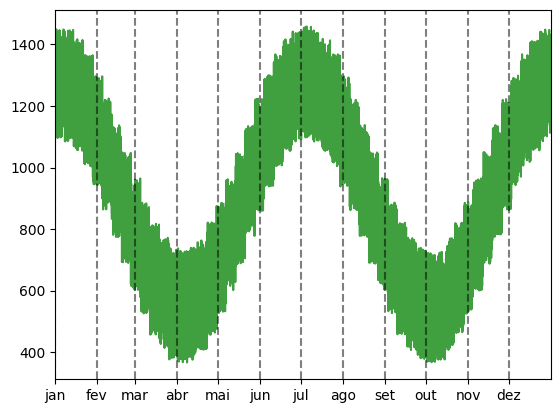

In [276]:
# Ajustar meus números aleatórios com base no comprimento do vetor de datas

# Extraindo o número de linhas/número de datas
n = df.shape[0]

atvMax = atv*(6/5)
atvMin = atv*(4/5)

atvMaxH = int(atvMax/(365*24))
atvMinH = int(atvMin/(365*24))

print(atvMaxH)
print(atvMinH)

# Criando atividade aleatória
atvArray = (atvMaxH - atvMinH)*np.random.rand(n) + atvMinH
df['atividade'] = atvArray

# Criando componente sazonal
sazonalidade = atvMinH*np.cos((2*np.pi)*(df['Semana']-1)/26)/2
df['sazonalidade'] = sazonalidade
print(df)

# Criando atividade real
atvHor = atvArray + sazonalidade
df['Atividade Horária'] = atvHor

# Configurando o locale para português
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')

# Criando uma figura com os valores aleatórios
fig, ax= plt.subplots()

ax.plot(df['Data'],df['Atividade Horária'], color = 'green', alpha = 0.75, label = 'Produção horária')
ax.plot(df['Data'],df['Atividade Horária'], color = 'green', alpha = 0.75)
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31 23:00:00'))

# Adicionando linha para cada mês
for date in pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS'):
    ax.axvline(x=date, color='black', linestyle='--', alpha=0.5)  # Escolha a cor, estilo e transparência conforme desejado

# Configurando o formato do eixo x para mostrar os meses abreviados
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Coloca um marcador em cada mês
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostra os três primeiros caracteres do mês

df.to_csv(r"C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\ativWEG.csv")